In [1]:
# --- 1. Importações ---
import pandas as pd
import numpy as np
import random
import time
import json
from collections import Counter
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# --- 2. Carregamento e Preparação dos Dados ---
df = pd.read_csv('dataset_com_id.csv')

# Remove classe 'Enrolled'
df_bin = df[df['Target'] != 'Enrolled'].copy()
print(f"Original: {len(df)} | Binário: {len(df_bin)}")
print("-" * 60)

X = df_bin.drop(['Target', 'ID'], axis=1)
y = df_bin['Target']

# Label Encoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Classes:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- Listas de Métricas ---
lst_results_mlp = []
lst_results_rf = []
best_params_mlp = []
best_params_rf = []
training_times_mlp = []
training_times_rf = []

# para salvar última execução
last_best_mlp = None
last_best_rf = None
last_scaler = None
last_pred_mlp = None
last_pred_rf = None

Original: 4424 | Binário: 3630
------------------------------------------------------------
Classes: ['Dropout' 'Graduate']


c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Evert\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 


RELATÓRIO FINAL – CENÁRIO BINÁRIO

--- MLP (GridSearch) ---
Melhores parâmetros: {'activation': 'logistic', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001}
Score validação: 0.9025502997210516
              precision    recall  f1-score   support

     Dropout       0.90      0.83      0.87       284
    Graduate       0.90      0.94      0.92       442

    accuracy                           0.90       726
   macro avg       0.90      0.89      0.89       726
weighted avg       0.90      0.90      0.90       726


--- Random Forest (GridSearch) ---
Melhores parâmetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Score validação: 0.9053053593685085
              precision    recall  f1-score   support

     Dropout       0.95      0.81      0.88       284
    Graduate       0.89      0.97      0.93       442

    accuracy                           0.91       726
   macro avg       0.92      0.89      0.90       726
weighted avg       0.91      0.91      0.9

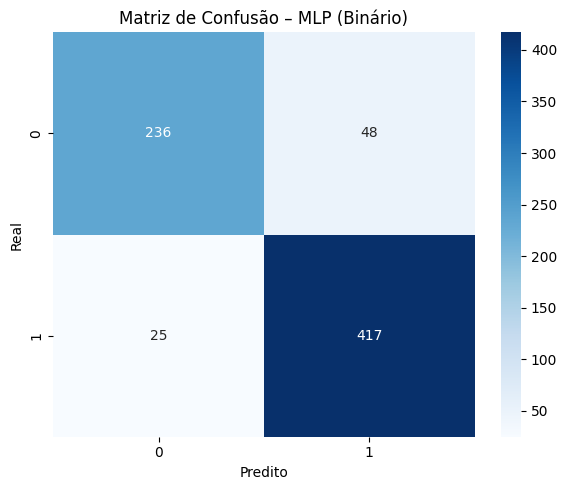

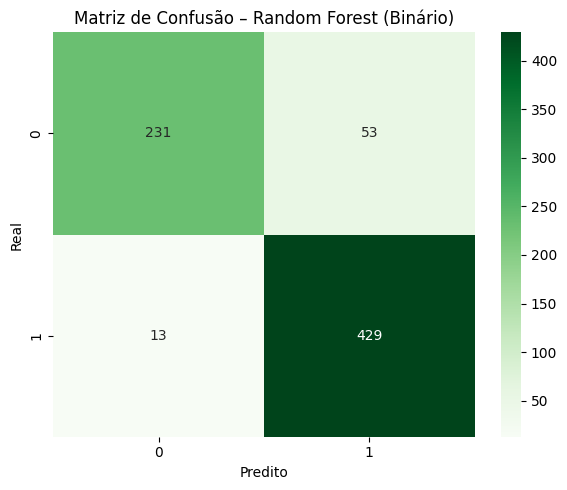

In [3]:
# --- 3. Loop de 30 execuções ---
for i in range(30):
    sd = i
    np.random.seed(sd)
    random.seed(sd)

    # Padronização
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------- MLP --------
    param_grid_mlp = {
        'hidden_layer_sizes': [(10,), (20,), (30,), (40,)],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'activation': ['logistic', 'tanh', 'relu']
    }

    mlp = MLPClassifier(solver='adam', max_iter=1000, random_state=sd)

    start = time.time()
    grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, n_jobs=-1, verbose=0)
    grid_mlp.fit(X_train_scaled, y_train)
    training_times_mlp.append(time.time() - start)

    best_mlp = grid_mlp.best_estimator_
    best_params_mlp.append(grid_mlp.best_params_)

    pred_test_mlp = best_mlp.predict(X_test_scaled)
    acc_test_mlp = accuracy_score(y_test, pred_test_mlp)
    lst_results_mlp.append(acc_test_mlp)

    # -------- Random Forest --------
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    rf = RandomForestClassifier(random_state=sd)

    start = time.time()
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=0)
    grid_rf.fit(X_train, y_train)
    training_times_rf.append(time.time() - start)

    best_rf = grid_rf.best_estimator_
    best_params_rf.append(grid_rf.best_params_)

    pred_test_rf = best_rf.predict(X_test)
    acc_test_rf = accuracy_score(y_test, pred_test_rf)
    lst_results_rf.append(acc_test_rf)

    # --- Última Execução (i = 29) ---
    if i == 29:
        last_best_mlp = best_mlp
        last_best_rf = best_rf
        last_scaler = scaler
        last_pred_mlp = pred_test_mlp
        last_pred_rf = pred_test_rf

        print("\n" + "="*60)
        print("RELATÓRIO FINAL – CENÁRIO BINÁRIO")
        print("="*60)

        print("\n--- MLP (GridSearch) ---")
        print("Melhores parâmetros:", grid_mlp.best_params_)
        print("Score validação:", grid_mlp.best_score_)
        print(classification_report(y_test, pred_test_mlp, target_names=le.classes_))

        print("\n--- Random Forest (GridSearch) ---")
        print("Melhores parâmetros:", grid_rf.best_params_)
        print("Score validação:", grid_rf.best_score_)
        print(classification_report(y_test, pred_test_rf, target_names=le.classes_))

        # --- Matrizes de Confusão + PNG ---
        cm_mlp = confusion_matrix(y_test, pred_test_mlp)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues")
        plt.title("Matriz de Confusão – MLP (Binário)")
        plt.xlabel("Predito"); plt.ylabel("Real")
        plt.tight_layout()
        plt.savefig("matriz_confusao_mlp_binario.png")
        plt.show()
        plt.close()

        cm_rf = confusion_matrix(y_test, pred_test_rf)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
        plt.title("Matriz de Confusão – Random Forest (Binário)")
        plt.xlabel("Predito"); plt.ylabel("Real")
        plt.tight_layout()
        plt.savefig("matriz_confusao_rf_binario.png")
        plt.show()
        plt.close()

In [4]:
# --- 4. Resultados Finais ---
print("\n" + "="*60)
print("RESULTADOS FINAIS – 30 EXECUÇÕES (BINÁRIO)")
print("="*60)

print(f"\nMLP – Acurácia média:  {np.mean(lst_results_mlp):.4f}")
print(f"MLP – Desvio padrão:   {np.std(lst_results_mlp):.4f}")

print(f"\nRF – Acurácia média:   {np.mean(lst_results_rf):.4f}")
print(f"RF – Desvio padrão:    {np.std(lst_results_rf):.4f}")


RESULTADOS FINAIS – 30 EXECUÇÕES (BINÁRIO)

MLP – Acurácia média:  0.9050
MLP – Desvio padrão:   0.0061

RF – Acurácia média:   0.9104
RF – Desvio padrão:    0.0033


In [5]:
# --- 5. Resumo dos parâmetros ---
print("\n--- Parâmetros mais frequentes (MLP) ---")
mlp_strs = [json.dumps(p, sort_keys=True) for p in best_params_mlp]
for p,c in Counter(mlp_strs).most_common(3):
    print(c, "→", p)

print("\n--- Parâmetros mais frequentes (RF) ---")
rf_strs = [json.dumps(p, sort_keys=True) for p in best_params_rf]
for p,c in Counter(rf_strs).most_common(3):
    print(c, "→", p)


--- Parâmetros mais frequentes (MLP) ---
27 → {"activation": "logistic", "hidden_layer_sizes": [10], "learning_rate_init": 0.001}
2 → {"activation": "logistic", "hidden_layer_sizes": [20], "learning_rate_init": 0.001}
1 → {"activation": "logistic", "hidden_layer_sizes": [30], "learning_rate_init": 0.001}

--- Parâmetros mais frequentes (RF) ---
4 → {"max_depth": 20, "min_samples_split": 2, "n_estimators": 100}
4 → {"max_depth": 20, "min_samples_split": 2, "n_estimators": 200}
3 → {"max_depth": null, "min_samples_split": 2, "n_estimators": 50}


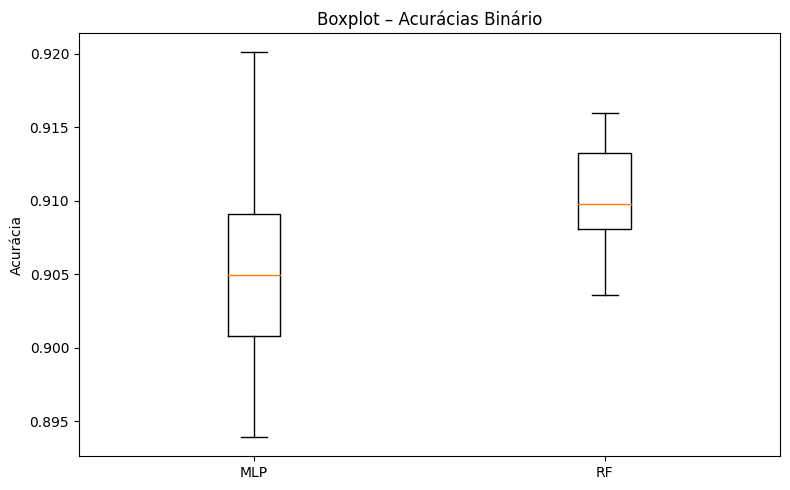

In [6]:
# --- 6. Boxplot ---
plt.figure(figsize=(8,5))
plt.boxplot([lst_results_mlp, lst_results_rf], labels=["MLP", "RF"])
plt.title("Boxplot – Acurácias Binário")
plt.ylabel("Acurácia")
plt.tight_layout()
plt.show()

In [9]:
# --- 7. CSV ---
df_csv = pd.DataFrame({
    "accuracy_mlp": lst_results_mlp,
    "accuracy_rf": lst_results_rf,
    "tempo_mlp": training_times_mlp,
    "tempo_rf": training_times_rf
})
df_csv.to_csv("resultados_binario.csv", index=False)
print("CSV Salvo: resultados_binario.csv")

CSV Salvo: resultados_binario.csv


In [10]:
# --- 8. Salvamento dos modelos + scaler + encoder + estatísticas ---
joblib.dump(last_best_mlp, "mlp_binario.pkl")
joblib.dump(last_best_rf, "rf_binario.pkl")
joblib.dump(last_scaler, "scaler_binario.pkl")
joblib.dump(le, "label_encoder_binario.pkl")

# Estatísticas do MLP
mlp_stats = {
    "loss_curve": getattr(last_best_mlp, "loss_curve_", None),
    "n_iter": getattr(last_best_mlp, "n_iter_", None)
}
joblib.dump(mlp_stats, "mlp_stats_binario.pkl")

# Estatísticas RF
rf_stats = {
    "feature_importances": getattr(last_best_rf, "feature_importances_", None)
}
joblib.dump(rf_stats, "rf_stats_binario.pkl")

print("\nArquivos exportados com sucesso!")
print("- mlp_binario.pkl")
print("- rf_binario.pkl")
print("- scaler_binario.pkl")
print("- label_encoder_binario.pkl")
print("- mlp_stats_binario.pkl")
print("- rf_stats_binario.pkl")
print("- matrizes de confusão PNG")
print("- resultados_binario.csv")


Arquivos exportados com sucesso!
- mlp_binario.pkl
- rf_binario.pkl
- scaler_binario.pkl
- label_encoder_binario.pkl
- mlp_stats_binario.pkl
- rf_stats_binario.pkl
- matrizes de confusão PNG
- resultados_binario.csv
